 # Project - YouTube Trending Video Statistic Analysis and  Modeling 

Data Source: https://www.kaggle.com/datasnaek/youtube-new/data

#### 2.2.5 Analyzing Comment words and emojis

In [ ]:
import numpy as np
import pandas as pd
import json 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()
import plotly.plotly as py
import plotly.graph_objs as go


from textblob import TextBlob
from wordcloud import WordCloud,STOPWORDS
import re
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier



In [ ]:
# Load video Files and comment Files 
path = '/Users/celia/Desktop/DS2017/FinalProject/data/youtube_with_comments/'
us_comments =pd.read_csv(path+'UScomments.csv', error_bad_lines = False)
uk_comments =pd.read_csv(path+'GBcomments.csv', error_bad_lines = False)
us_video =pd.read_csv(path+'USvideos.csv',error_bad_lines = False)
uk_video =pd.read_csv(path+'USvideos.csv',error_bad_lines = False)

In [3]:
us_video['country'] ='US'
uk_video['country'] ='UK'
print(us_comments.shape)
print(us_comments.drop_duplicates().shape)
print(uk_comments.shape)
print(uk_comments.drop_duplicates().shape)
print(us_video.shape)
print(us_video.drop_duplicates().shape)
print(uk_video.shape)
print(uk_video.drop_duplicates().shape)


(691400, 4)
(478707, 4)
(718452, 4)
(408291, 4)
(7992, 12)
(7992, 12)
(7992, 12)
(7992, 12)


In [4]:
# Drop record duplicates frow raw data
us_comment= us_comments.drop_duplicates()
uk_comment= uk_comments.drop_duplicates()
total_video = pd.concat([us_video,uk_video])
total_comment = pd.concat([us_comment,uk_comment])
print(total_video.info())
print(total_comment.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 15984 entries, 0 to 7991
Data columns (total 12 columns):
video_id          15984 non-null object
title             15984 non-null object
channel_title     15984 non-null object
category_id       15984 non-null int64
tags              15984 non-null object
views             15984 non-null int64
likes             15984 non-null int64
dislikes          15984 non-null int64
comment_total     15984 non-null int64
thumbnail_link    15984 non-null object
date              15984 non-null float64
country           15984 non-null object
dtypes: float64(1), int64(5), object(6)
memory usage: 1.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 886998 entries, 0 to 718451
Data columns (total 4 columns):
video_id        886998 non-null object
comment_text    886968 non-null object
likes           886998 non-null object
replies         886998 non-null object
dtypes: object(4)
memory usage: 33.8+ MB
None


In [5]:
# Load JSon file and create a mapping look-up list of video category id and video category from category table
with open(path+'US_category_id.json', 'r') as raw:
    uscat = json.load(raw)
#print(list(filter(lambda x: x['kind'] ==  'youtube#videoCategory', uscat['items'][:3])))
# convert Jason to DataFrame
items = pd.DataFrame(uscat['items'])
items = items.join(items.snippet.apply(lambda x: pd.Series(x)))
us_mapping = {}
for category in uscat['items']:
        us_mapping[category['id']] = category['snippet']['title']
print(us_mapping)
print(items.info())

{'1': 'Film & Animation', '2': 'Autos & Vehicles', '10': 'Music', '15': 'Pets & Animals', '17': 'Sports', '18': 'Short Movies', '19': 'Travel & Events', '20': 'Gaming', '21': 'Videoblogging', '22': 'People & Blogs', '23': 'Comedy', '24': 'Entertainment', '25': 'News & Politics', '26': 'Howto & Style', '27': 'Education', '28': 'Science & Technology', '29': 'Nonprofits & Activism', '30': 'Movies', '31': 'Anime/Animation', '32': 'Action/Adventure', '33': 'Classics', '34': 'Comedy', '35': 'Documentary', '36': 'Drama', '37': 'Family', '38': 'Foreign', '39': 'Horror', '40': 'Sci-Fi/Fantasy', '41': 'Thriller', '42': 'Shorts', '43': 'Shows', '44': 'Trailers'}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 7 columns):
etag          32 non-null object
id            32 non-null object
kind          32 non-null object
snippet       32 non-null object
assignable    32 non-null bool
channelId     32 non-null object
title         32 non-null object
dtypes: b

In [6]:
# Adding Category field into Video table 
mapping_list = items[['id','title']]
mapping_list['id']=mapping_list['id'].astype(int)
# Add video category into video data table 
video_data=total_video.merge(mapping_list, how='left', left_on='category_id', right_on='id')
video_data=video_data.drop('id',axis =1)
video_data.rename(columns = {'title_y':'category'}, inplace = True)
video_data.rename(columns = {'title_x':'video_title'}, inplace = True)
video_data.head(3)

/Users/celia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,video_id,video_title,channel_title,category_id,tags,views,likes,dislikes,comment_total,thumbnail_link,date,country,category
0,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,https://i.ytimg.com/vi/XpVt6Z1Gjjo/default.jpg,13.09,US,Entertainment
1,K4wEI5zhHB0,iPhone X — Introducing iPhone X — Apple,Apple,28,Apple|iPhone 10|iPhone Ten|iPhone|Portrait Lig...,7860119,185853,26679,0,https://i.ytimg.com/vi/K4wEI5zhHB0/default.jpg,13.09,US,Science & Technology
2,cLdxuaxaQwc,My Response,PewDiePie,22,[none],5845909,576597,39774,170708,https://i.ytimg.com/vi/cLdxuaxaQwc/default.jpg,13.09,US,People & Blogs


In [136]:
total_comment.head(15)

,video_id,comment_text,likes,replies
0,XpVt6Z1Gjjo,Logan Paul it's yo big day ‼️‼️‼️,4,0
1,XpVt6Z1Gjjo,I've been following you from the start of your...,3,0
2,XpVt6Z1Gjjo,Say hi to Kong and maverick for me,3,0
3,XpVt6Z1Gjjo,MY FAN . attendance,3,0
4,XpVt6Z1Gjjo,trending 😉,3,0
5,XpVt6Z1Gjjo,#1 on trending AYYEEEEE,3,0
6,XpVt6Z1Gjjo,The end though 😭👍🏻❤️,4,0
7,XpVt6Z1Gjjo,#1 trending!!!!!!!!!,3,0
8,XpVt6Z1Gjjo,Happy one year vlogaversary,3,0
9,XpVt6Z1Gjjo,You and your shit brother may have single hand...,0,0


In [8]:
# Create a mapping lookup list of video id and category from video table 
id_category_mapping = video_data[['video_id','category']].drop_duplicates()
id_category_mapping.isnull().sum()

video_id    0
category    0
dtype: int64

In [9]:
# Add category into comment table 
comment_data=total_comment.merge(id_category_mapping, how='left', on='video_id')
print(comment_data.isnull().sum())

video_id             0
comment_text        30
likes                0
replies              0
category        154344
dtype: int64


In [10]:
# Check if all video IDs exists in three tables - video table, lookup table, comment table 
print(video_data.video_id.nunique())
print(id_category_mapping.video_id.nunique())
print(comment_data.video_id.nunique())

2364
2364
3150


In [11]:
# Drop those video IDs in comment table which do not exist in video table or look up table; 
# Those video are not trending videos and also cannot be labeled by video category
comment_data =comment_data[(comment_data.comment_text.notnull())&(comment_data.category.notnull())]
comment_data.isnull().sum()
print(comment_data.video_id.nunique())
comment_data.groupby('category')['video_id'].nunique()

2266


category
Autos & Vehicles          35
Comedy                   211
Education                 89
Entertainment            458
Film & Animation          97
Gaming                    28
Howto & Style            260
Music                    329
News & Politics          175
Nonprofits & Activism      2
People & Blogs           246
Pets & Animals            37
Science & Technology     144
Shows                      1
Sports                   139
Travel & Events           17
Name: video_id, dtype: int64

In [12]:
# Because there are duplicates between US dataset and UK dataset, 
# I will create three datasets - 1) UK only 2) US only 3) Total records but eliminated duplicates between US and UK

video_us = video_data[video_data['country']=='US']
video_uk = video_data[video_data['country']=='UK']
video_total = video_data.drop('country', axis=1)
video_total = video_total.drop_duplicates()
print(video_total.shape)
print(video_us.shape)
print(video_uk.shape)

(7992, 12)
(7992, 13)
(7992, 13)


In [13]:
import re

# Clearning urls
def remove_urls(x):
    return re.sub(r"http\S+", "", x)

# correct spelling (http://textblob.readthedocs.io/en/dev/quickstart.html) --# running for hours so i have to cancel this
def correct_spelling(x):
    x = TextBlob(x)
    return str(x.correct())

# translate non-English language into English ???
#def translation(x):
    #x = TextBlob(u'',x)
    #if x.detect_language()='en'

# emoji pattern (https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python)
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

# removing non-ASCII characters and emoji
def exASCII(x):
    # Lowercasing all words
    x = x.lower()
    # Removing non ASCII chars
    #ex_ascii = re.sub(r'[^\x00-\x7f]',r'',x)
    # remove emoji
    #return emoji_pattern.sub(r'', ex_ascii)
    return emoji_pattern.sub(r'', x)

# replace trippled+ characters
# https://stackoverflow.com/questions/43110237/replace-consecutive-repeated-characters-with-one-column-wise-operation-pand
def trim_trippled(x):
    min_threshold_rep = 3
    return re.sub(r'(.)\1{%d,}'%(min_threshold_rep-1), r'\1',x)

# change shorcuts to full words, replace remains of unwanted characters
# thanks to https://www.analyticsvidhya.com/blog/2014/11/text-data-cleaning-steps-python/
apts = {"'s": " is",
        "'ll": " will",
        "'re": " are",
        "'d": " would",
        "'t": " not",
        "'m": " am",
        "'ve": " have",
        "&": " and ",
        "\*": " ",
        r'\\n': " ",
        '[%_=>#"(--)\)\(:\^~\<( - )( / )([\\\/\])]': " ",
        "[^(\d]\d+\)": " ",
        "([\d|\d\d]):([\d|\d\d])(:([\d|\d\d]))?": " "}

# exclude double spaces left after previous step
rem = {'  +': ' '}

def ex_apts_rem(x):
    for i in apts:
        x = re.sub(i, apts[i], x)
    for i in rem:
        x = re.sub(i, rem[i], x)
    return x

# function that embraces all previous text preparation process
def preprocess_functions(x):
    return ex_apts_rem(trim_trippled(exASCII(remove_urls(x))))
# Call function and create a new comment text 
comment_data['comment_text_new'] = comment_data['comment_text'].apply(lambda x: preprocess_functions(str(x)))

In [15]:
comment_data['comment_text_new'].head()

0                   logan paul it is yo big day ‼️‼️‼️
1    i have been following you from the start of yo...
2                   say hi to kong and maverick for me
3                                  my fan . attendance
4                                            trending 
Name: comment_text_new, dtype: object

In [16]:
# List the most frequent emojis in total comments

# prepare emojis list
comment_data['emoji'] = comment_data['comment_text'].apply(lambda x: re.findall(emoji_pattern, str(x))) # find emoji
comment_data['emoji'] = comment_data['emoji'].apply(lambda x: [i for sublist in x for i in sublist])
emoji_list = comment_data['emoji'].values.tolist()
emoji_list_new = [i for sublist in emoji_list for i in sublist] # convert from list of lists to single list
emoji_list_new
emoji_unique = list(set(emoji_list_new)) # only unique values from the list
emoji_all = " ".join(emoji_list_new)
# dictionary for emoji frequency
emoji_dict = {}
for i in emoji_unique:
    emoji_dict[i] = len(re.findall(i, emoji_all))
# Plot top 5 emoji 
emoji_df = pd.DataFrame.from_dict(emoji_dict, orient = 'index')
emoji_df = emoji_df.reset_index()
emoji_df.columns = ["emoji", 'frequency']
emoji_df.sort_values('frequency', ascending = False, inplace = True)
emoji_df_top10 = emoji_df.head(10).copy()
emoji_df_top10
#emoji_df_top5.sort_values('frequency', ascending = True, inplace = True).plot(kind='barh')



,emoji,frequency
247,😂,42776
195,😍,36057
131,😭,9938
301,🔥,9766
44,😘,6939
322,💖,6264
219,👏,6071
115,💕,5891
272,👍,5878
103,💜,3964


In [17]:
# List the most frequent emojis in US comments

us_comment['emoji'] = us_comment['comment_text'].apply(lambda x: re.findall(emoji_pattern, str(x))) # find emoji
us_comment['emoji'] = us_comment['emoji'].apply(lambda x: [i for sublist in x for i in sublist])
us_emoji_list = us_comment['emoji'].values.tolist()
us_emoji_list_new = [i for sublist in us_emoji_list for i in sublist] # convert from list of lists to single list
us_emoji_unique = list(set(us_emoji_list_new)) # only unique values from the list
us_emoji_all = " ".join(us_emoji_list_new)
# dictionary for emoji frequency
us_emoji_dict = {}
for i in us_emoji_unique:
    us_emoji_dict[i] = len(re.findall(i, us_emoji_all))
# Plot top 5 emoji 
us_emoji_df = pd.DataFrame.from_dict(us_emoji_dict, orient = 'index')
us_emoji_df = us_emoji_df.reset_index()
us_emoji_df.columns = ["emoji", 'frequency']
us_emoji_df.sort_values('frequency', ascending = False, inplace = True)
us_emoji_df_top10 = us_emoji_df.head(10).copy()
us_emoji_df_top10
#emoji_df_top5.sort_values('frequency', ascending = True, inplace = True).plot(kind='barh')





/Users/celia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/celia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,emoji,frequency
244,😂,27287
193,😍,22145
297,🔥,6288
130,😭,6155
318,💖,4242
44,😘,4174
217,👏,4005
268,👍,3789
115,💕,3731
103,💜,2588


In [18]:
# Check UK emojis
uk_comment['emoji'] = uk_comment['comment_text'].apply(lambda x: re.findall(emoji_pattern, str(x))) # find emoji
uk_comment['emoji'] = uk_comment['emoji'].apply(lambda x: [i for sublist in x for i in sublist])
uk_emoji_list = uk_comment['emoji'].values.tolist()
uk_emoji_list_new = [i for sublist in uk_emoji_list for i in sublist] # convert from list of lists to single list
uk_emoji_unique = list(set(uk_emoji_list_new)) # only unique values from the list
uk_emoji_all = " ".join(uk_emoji_list_new)
# dictionary for emoji frequency
uk_emoji_dict = {}
for i in uk_emoji_unique:
    uk_emoji_dict[i] = len(re.findall(i, uk_emoji_all))
# Plot top 5 emoji 
uk_emoji_df = pd.DataFrame.from_dict(uk_emoji_dict, orient = 'index')
uk_emoji_df = uk_emoji_df.reset_index()
uk_emoji_df.columns = ["emoji", 'frequency']
uk_emoji_df.sort_values('frequency', ascending = False, inplace = True)
uk_emoji_df_top10 = uk_emoji_df.head(10).copy()
uk_emoji_df_top10
#emoji_df_top5.sort_values('frequency', ascending = True, inplace = True).plot(kind='barh')



/Users/celia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/celia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,emoji,frequency
247,😂,25253
195,😍,21543
300,🔥,7066
131,😭,5755
45,😘,3967
115,💕,3763
271,👍,3539
219,👏,3285
321,💖,2935
817,😊,2540


In [19]:
comment_data.head()

,video_id,comment_text,likes,replies,category,comment_text_new,emoji
0,XpVt6Z1Gjjo,Logan Paul it's yo big day ‼️‼️‼️,4,0,Entertainment,logan paul it is yo big day ‼️‼️‼️,[]
1,XpVt6Z1Gjjo,I've been following you from the start of your...,3,0,Entertainment,i have been following you from the start of yo...,[]
2,XpVt6Z1Gjjo,Say hi to Kong and maverick for me,3,0,Entertainment,say hi to kong and maverick for me,[]
3,XpVt6Z1Gjjo,MY FAN . attendance,3,0,Entertainment,my fan . attendance,[]
4,XpVt6Z1Gjjo,trending 😉,3,0,Entertainment,trending,[😉]


## Part 3 - Building A Video Category Classifier

### 3.1 Feature Exaction and Training Set Creation

In [137]:
# Predicting video categories based on video comments
# Due to big data size and long model running, 
# here I selected five categories among 16 categories to build a ML classifier

target_list =['Music', 'News & Politics', 'Sports', 'Nonprofits & Activism','Education']
target_data = comment_data.loc[comment_data['category'].isin(target_list)] 
X, y = target_data.comment_text_new, target_data.category
len(target_data)

218364

In [21]:
# Transform X to matrix with CountVectorizer and TfidfVectorizer

CV= CountVectorizer(stop_words='english', ngram_range=(1,3))
X_CV = CV.fit_transform(X)
#X_test_CV = CV.fit_transform(X_test)

tfidfv = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
X_tfidfv = tfidfv.fit_transform(X)
#X_test_tfidfv = tfidfv.fit_transform(X_test)

print(X_CV.shape)
print(X_tfidfv.shape)
print(y.shape)


(218364, 1442893)
(218364, 1442893)
(218364,)


In [22]:
X_train_CV, X_test_CV, y_train, y_test = train_test_split(X_CV,y, train_size=.8, random_state=50) 
X_train_TV, X_test_TV, y_train, y_test = train_test_split(X_tfidfv,y, train_size=.8, random_state=50) 

### 3.2 Multinomial Naive Bayes Estimator

In [23]:
# Multinomial Naive Bayes estimator 
model_nb = MultinomialNB()
CV_score = cross_val_score(model_nb.fit(X_train_CV, y_train), X_test_CV,y_test,cv=5).mean()
tfidfv_score = cross_val_score(model_nb.fit(X_train_TV, y_train), X_test_TV,y_test,cv=5).mean()
print(CV_score)
print(tfidfv_score)

0.739106547581
0.605110737361


In [24]:
print (target_list)
print (model_nb.classes_)
print (model_nb.class_count_)
print (model_nb.class_log_prior_)

['Music', 'News & Politics', 'Sports', 'Nonprofits & Activism', 'Education']
['Education' 'Music' 'News & Politics' 'Nonprofits & Activism' 'Sports']
[  2.32440000e+04   1.03810000e+05   2.89330000e+04   5.60000000e+01
   1.86480000e+04]
[-2.01697166 -0.52045639 -1.79803589 -8.04542229 -2.2372798 ]


In [26]:
print (model_nb.feature_count_)
print (model_nb.coef_)

[[  9.17586949   0.           0.         ...,   0.           0.           0.        ]
 [ 41.84735321   6.75504303   3.45134265 ...,   0.           0.           0.        ]
 [  9.17090945   0.07767031   0.         ...,   0.21035234   0.21035234
    0.21035234]
 [  0.           0.           0.         ...,   0.           0.           0.        ]
 [  7.57084168   0.39050282   0.         ...,   0.           0.           0.        ]]
[[-11.92399211 -14.24401129 -14.24401129 ..., -14.24401129 -14.24401129
  -14.24401129]
 [-10.61844843 -12.32774896 -12.88288653 ..., -14.3760923  -14.3760923
  -14.3760923 ]
 [-11.94209235 -14.1868224  -14.26162398 ..., -14.07071248 -14.07071248
  -14.07071248]
 [-14.18231044 -14.18231044 -14.18231044 ..., -14.18231044 -14.18231044
  -14.18231044]
 [-12.07769188 -13.8963924  -14.22605782 ..., -14.22605782 -14.22605782
  -14.22605782]]


In [29]:
pd.DataFrame([model_nb.class_count_,model_nb.class_log_prior_], 
             index = ['class_count','class_log_prior'],
            columns =model_nb.classes_ )

,Education,Music,News & Politics,Nonprofits & Activism,Sports
class_count,23244.000000,103810.000000,28933.000000,56.000000,18648.00000
class_log_prior,-2.016972,-0.520456,-1.798036,-8.045422,-2.23728


In [46]:
coef = pd.DataFrame(model_nb.coef_, columns=CV.get_feature_names(), index= model_nb.classes_).T
coef.tail(10)

,Education,Music,News & Politics,Nonprofits & Activism,Sports
𝕔𝕠𝕕𝕖𝕤 claimyourfreepromocode,-14.244011,-14.376092,-14.070712,-14.18231,-14.226058
𝕡𝕣𝕠𝕞𝕠,-14.244011,-14.376092,-14.070712,-14.18231,-14.226058
𝕡𝕣𝕠𝕞𝕠 𝕔𝕠𝕕𝕖𝕤,-14.244011,-14.376092,-14.070712,-14.18231,-14.226058
𝕡𝕣𝕠𝕞𝕠 𝕔𝕠𝕕𝕖𝕤 claimyourfreepromocode,-14.244011,-14.376092,-14.070712,-14.18231,-14.226058
𝟚𝟝𝟘,-14.244011,-14.376092,-14.063886,-14.18231,-14.226058
𝟚𝟝𝟘 𝕊𝕜𝕪𝕡𝕖,-14.244011,-14.376092,-14.063886,-14.18231,-14.226058
𝟚𝟝𝟘 𝕊𝕜𝕪𝕡𝕖 ℂ𝕣𝕖𝕕𝕚𝕥𝕤,-14.244011,-14.376092,-14.063886,-14.18231,-14.226058
𝟝𝟘𝟘,-14.244011,-14.376092,-14.070712,-14.18231,-14.226058
𝟝𝟘𝟘 𝕡𝕣𝕠𝕞𝕠,-14.244011,-14.376092,-14.070712,-14.18231,-14.226058
𝟝𝟘𝟘 𝕡𝕣𝕠𝕞𝕠 𝕔𝕠𝕕𝕖𝕤,-14.244011,-14.376092,-14.070712,-14.18231,-14.226058


In [44]:
# List words from comments with high and low coefficients from our Naive Baynes model

top = 20
for co in coef:
    s = coef[[co]].sort_values(co)
    #top_20 = co, ", ".join(s.iloc[-top:].index)

    print ("%-20s  (+) %s" % (co, ", ".join(s.iloc[-top:].index)))
    print ("%-20s  (-) %s" % ("", ", ".join(s.iloc[:top].index)))
    
    ## + and - means based on coefficient group them high and low coefficient ones

Education             (+) interesting, life, cool, time, want, really, love, great, videos, simulation, think, good, know, live, make, don, people, just, like, video
                      (-) like stations playing, passengers clean, passengers burnt hair, passengers burnt, passengers boarding just, passengers boarding, passengers best interests, passengers best, passengers allergy pets, passengers allergy, passenger van small, passenger van, passenger second woman, passenger second, passenger seats airplane, passenger seats, passengers clean plane, passengers complaints, passengers complaints uber, passengers distraction
Music                 (+) new, yes, perfect, nice, awesome, great, voice, just, omg, best, music, wow, love song, video, like, good, beautiful, amazing, song, love
                      (-) 𝟝𝟘𝟘 𝕡𝕣𝕠𝕞𝕠 𝕔𝕠𝕕𝕖𝕤, make makes atoms, make making, make making bad, make manganese, make manganese metal, make market, make market drain, make mars, make mars want, make mascara, make 

In [51]:
def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            #if 'http' not in word
                                #and not word.startswith('@')
                                #and not word.startswith('#')
                                #and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(8, 8))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

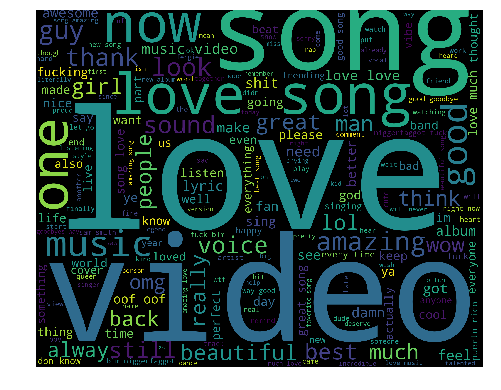

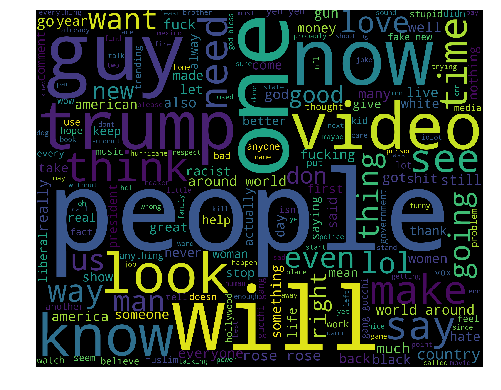

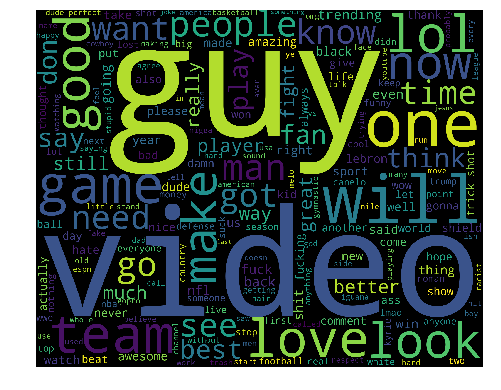

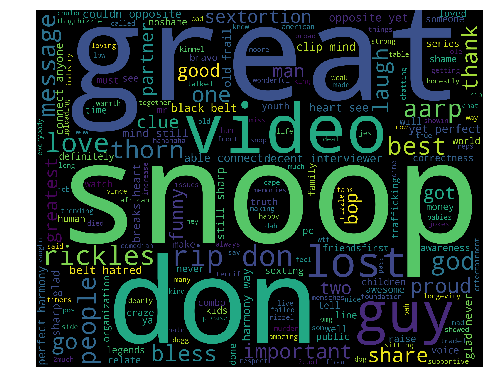

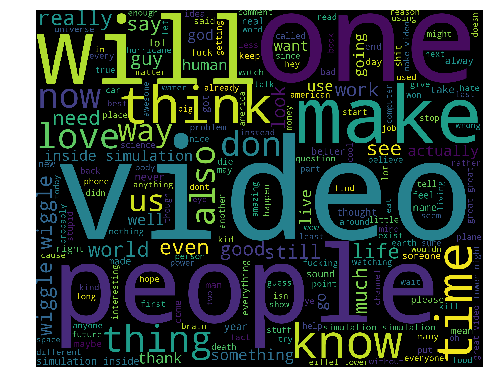

In [52]:
for cate in target_list:
    wordcloud_draw(target_data[target_data['category']==cate].comment_text_new)

In [ ]:
print (target_list)
print (model_nb.classes_)
print (model_nb.class_count_)
print (model_nb.class_log_prior_)

### 3.3 Dimension Reduction with t-SNE

In [53]:
# Reduce dimension
import random
random.seed(40)

X_reduced = TruncatedSVD(n_components=50, random_state=0).fit_transform(X_CV)
X_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(X_reduced)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 218364 samples in 1.268s...
[t-SNE] Computed neighbors for 218364 samples in 1027.760s...
[t-SNE] Computed conditional probabilities for sample 1000 / 218364
[t-SNE] Computed conditional probabilities for sample 2000 / 218364
[t-SNE] Computed conditional probabilities for sample 3000 / 218364
[t-SNE] Computed conditional probabilities for sample 4000 / 218364
[t-SNE] Computed conditional probabilities for sample 5000 / 218364
[t-SNE] Computed conditional probabilities for sample 6000 / 218364
[t-SNE] Computed conditional probabilities for sample 7000 / 218364
[t-SNE] Computed conditional probabilities for sample 8000 / 218364
[t-SNE] Computed conditional probabilities for sample 9000 / 218364
[t-SNE] Computed conditional probabilities for sample 10000 / 218364
[t-SNE] Computed conditional probabilities for sample 11000 / 218364
[t-SNE] Computed conditional probabilities for sample 12000 / 218364
[t-SNE] Computed conditional pro

[t-SNE] Computed conditional probabilities in 17.977s
[t-SNE] Iteration 50: error = 110.6742477, gradient norm = 0.0000001 (50 iterations in 582.138s)
[t-SNE] Iteration 100: error = 110.6738510, gradient norm = 0.0000074 (50 iterations in 587.061s)
[t-SNE] Iteration 150: error = 109.5060730, gradient norm = 0.0014745 (50 iterations in 587.675s)
[t-SNE] Iteration 200: error = 92.5130692, gradient norm = 0.0014076 (50 iterations in 538.860s)
[t-SNE] Iteration 250: error = 86.6738358, gradient norm = 0.0010213 (50 iterations in 510.861s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.673836
[t-SNE] Iteration 300: error = 5.0946460, gradient norm = 0.0007924 (50 iterations in 500.158s)
[t-SNE] Iteration 350: error = 4.8272676, gradient norm = 0.0006111 (50 iterations in 489.481s)
[t-SNE] Iteration 400: error = 4.5382776, gradient norm = 0.0004777 (50 iterations in 473.651s)
[t-SNE] Iteration 450: error = 4.2957072, gradient norm = 0.0003818 (50 iterations in 465.048

In [73]:
X_embedded

array([[-14.7113905 ,   7.6035285 ],
       [ -1.75569034,   0.74212849],
       [-20.38113022,  -9.66341972],
       ..., 
       [ 11.51410675,  27.67478943],
       [-24.26696396,  22.26846886],
       [-23.135149  ,  -0.74757218]], dtype=float32)

In [102]:
# Multinomial Naive Bayes estimator - After dimension deduction
X_scale =MinMaxScaler(feature_range=(0, 1), copy=True).fit_transform(X_embedded) # scale X because X has negative values 
X_train_CV, X_test_CV, y_train, y_test = train_test_split(X_scale,y, train_size=.8, random_state=50) 
model_nb = MultinomialNB()
CV_score_after = cross_val_score(model_nb.fit(X_train_CV, y_train), X_test_CV,y_test,cv=5).mean()

print(CV_score_after)


0.593547507719


In [91]:
print (target_list)
print (model_nb.classes_)
print (model_nb.class_count_)
print (model_nb.class_log_prior_)

['Music', 'News & Politics', 'Sports', 'Nonprofits & Activism', 'Education']
['Education' 'Music' 'News & Politics' 'Nonprofits & Activism' 'Sports']
[  2.32440000e+04   1.03810000e+05   2.89330000e+04   5.60000000e+01
   1.86480000e+04]
[-2.01697166 -0.52045639 -1.79803589 -8.04542229 -2.2372798 ]


In [101]:
# Give numeric number to five categories
y_dummy = pd.Categorical(y)
y_dummy.codes

array([1, 1, 1, ..., 1, 1, 1], dtype=int8)

In [83]:
%pylab inline

target_data.category
color_map =['r','b','g','v','y']
color = target_list
color = pd.Series()


Populating the interactive namespace from numpy and matplotlib


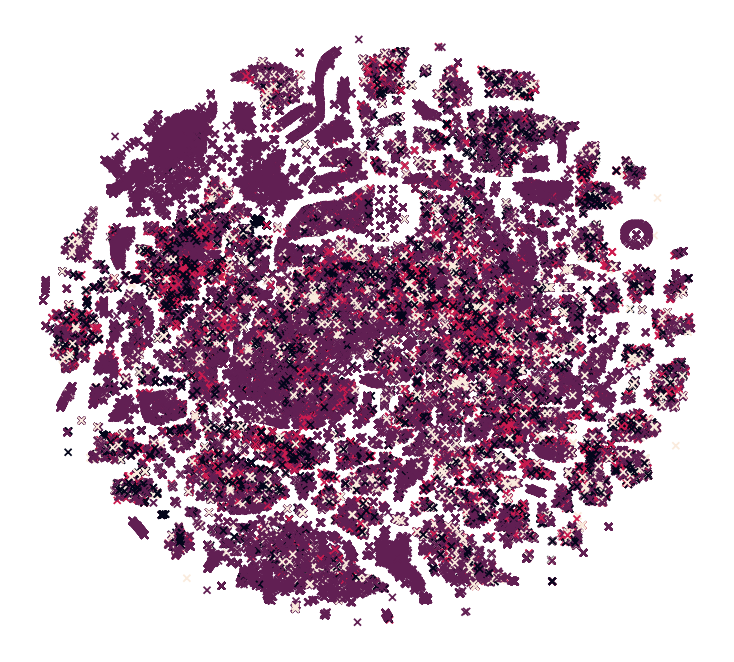

In [100]:
figure(figsize=(10, 10))
ax=axes(frameon=False)
setp(ax, xticks=(), yticks=())
subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9,wspace=0.0, hspace=0.0)
scatter(X_scale[:, 0], X_scale[:, 1],
        c=y_dummy.codes, marker="x")


### 3.4 Random Forest Estimator

In [103]:
# RandomForest estimator - After dimension deduction
model_rf = RandomForestClassifier(n_estimators=2)
%time cross_val_score(model_rf.fit(X_train_CV, y_train), X_test_CV,y_test).mean()

CPU times: user 884 ms, sys: 40.5 ms, total: 925 ms
Wall time: 941 ms


0.56075835587688028

In [104]:
# optimizing tree numbers
%time
scores = []
for n in [1, 2, 3, 5, 10, 20, 50, 100]:
    for criterion in ['gini', 'entropy']:
        start_time = time.time()  
        accuracy = cross_val_score(model_rf.fit(X_train_CV, y_train), X_test_CV,y_test).mean()  
        duration = time.time() - start_time
        scores.append(dict(n_estimators=n, criterion=criterion, accuracy=accuracy, duration=duration))
scores_rf = pd.DataFrame(scores)
scores_rf.head()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.91 µs


,accuracy,criterion,duration,n_estimators
0,0.558515,gini,0.901526,1
1,0.559453,entropy,0.867631,1
2,0.558789,gini,0.841515,2
3,0.562361,entropy,0.851598,2
4,0.561995,gini,0.851354,3


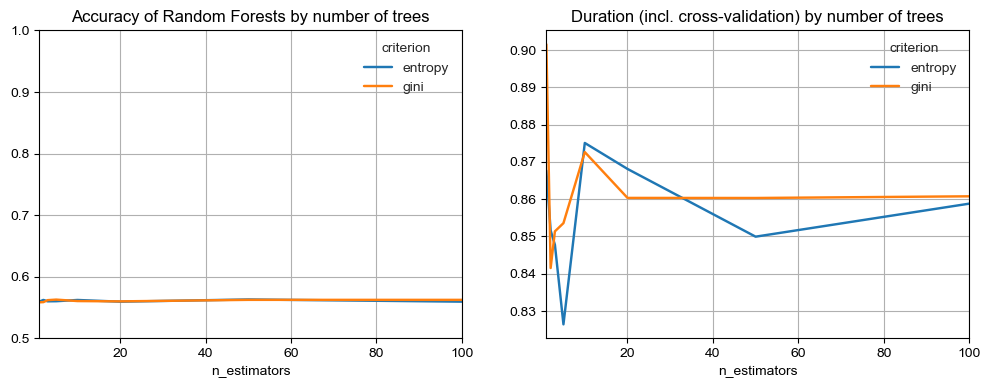

In [107]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plt.style.use('seaborn')
f = scores_rf.groupby(['n_estimators', 'criterion']).accuracy.mean().unstack() \
    .plot(ylim=(.5,1), title="Accuracy of Random Forests by number of trees", ax=axes[0])
f = scores_rf.groupby(['n_estimators', 'criterion']).duration.mean().unstack() \
    .plot(title="Duration (incl. cross-validation) by number of trees", ax=axes[1])    

In [108]:
scores_rf.groupby(['n_estimators', 'criterion']).accuracy.mean().unstack()

criterion,entropy,gini
n_estimators,,
1,0.559453,0.558515
2,0.562361,0.558789
3,0.560117,0.561995
5,0.560277,0.562888
10,0.562293,0.560529
20,0.559522,0.560026
50,0.563117,0.562499
100,0.559568,0.562475


### 3.5 AdaBoost Classifier Estimator

In [111]:
# AdaBoost Classifier - After dimension deduction
model_ada = AdaBoostClassifier(n_estimators=10)
%time cross_val_score(model_ada.fit(X_train_CV, y_train), X_test_CV,y_test).mean()

CPU times: user 1.32 s, sys: 104 ms, total: 1.43 s
Wall time: 1.43 s


0.59354750247941102

In [113]:
%time
scores = []
for n in [1, 2, 3, 5, 10, 20, 50, 100]:
    for criterion in ['gini', 'entropy']:
        start_time = time.time()  
        accuracy = cross_val_score(model_ada.fit(X_train_CV, y_train), X_test_CV,y_test).mean()  
        duration = time.time() - start_time
        scores.append(dict(n_estimators=n, criterion=criterion, accuracy=accuracy, duration=duration))
scores_ada = pd.DataFrame(scores)
scores_ada.head()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


,accuracy,criterion,duration,n_estimators
0,0.593548,gini,1.409105,1
1,0.593548,entropy,1.430044,1
2,0.593548,gini,1.329026,2
3,0.593548,entropy,1.343536,2
4,0.593548,gini,1.349724,3


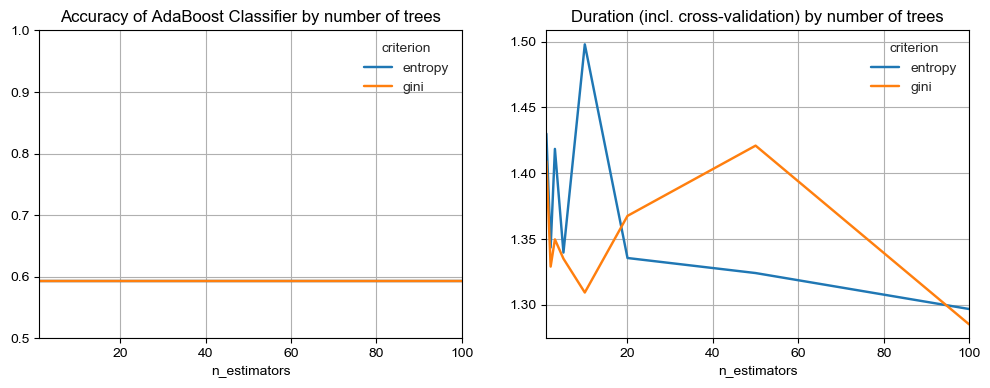

In [117]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plt.style.use('seaborn')
f = scores_ada.groupby(['n_estimators', 'criterion']).accuracy.mean().unstack() \
    .plot(ylim=(.5,1), title="Accuracy of AdaBoost Classifier by number of trees", ax=axes[0])
f = scores_ada.groupby(['n_estimators', 'criterion']).duration.mean().unstack() \
    .plot(title="Duration (incl. cross-validation) by number of trees", ax=axes[1])    

In [118]:
scores_ada.groupby(['n_estimators', 'criterion']).accuracy.mean().unstack()

criterion,entropy,gini
n_estimators,,
1,0.593548,0.593548
2,0.593548,0.593548
3,0.593548,0.593548
5,0.593548,0.593548
10,0.593548,0.593548
20,0.593548,0.593548
50,0.593548,0.593548
100,0.593548,0.593548


### 3.6 K-neighbors Classifier

In [120]:
# K neighbors Classifier - After dimension deduction
scores = {}
for k in range(1, 50):
    scores[k] = []
    for i in range(20):
        scores[k].append(KNeighborsClassifier(n_neighbors=k).fit(X_train_CV, y_train).score(X_test_CV,y_test))
sc = pd.DataFrame(scores)
sc.head()

,1,2,3,4,5,6,7,8,9,10,...,40,41,42,43,44,45,46,47,48,49
0,0.724315,0.672544,0.640396,0.633481,0.637236,0.629428,0.633068,0.626382,0.630527,0.629107,...,0.626932,0.627161,0.626611,0.625696,0.62565,0.626062,0.625833,0.625421,0.625306,0.625673
1,0.724315,0.672544,0.640396,0.633481,0.637236,0.629428,0.633068,0.626382,0.630527,0.629107,...,0.626932,0.627161,0.626611,0.625696,0.62565,0.626062,0.625833,0.625421,0.625306,0.625673
2,0.724315,0.672544,0.640396,0.633481,0.637236,0.629428,0.633068,0.626382,0.630527,0.629107,...,0.626932,0.627161,0.626611,0.625696,0.62565,0.626062,0.625833,0.625421,0.625306,0.625673
3,0.724315,0.672544,0.640396,0.633481,0.637236,0.629428,0.633068,0.626382,0.630527,0.629107,...,0.626932,0.627161,0.626611,0.625696,0.62565,0.626062,0.625833,0.625421,0.625306,0.625673
4,0.724315,0.672544,0.640396,0.633481,0.637236,0.629428,0.633068,0.626382,0.630527,0.629107,...,0.626932,0.627161,0.626611,0.625696,0.62565,0.626062,0.625833,0.625421,0.625306,0.625673


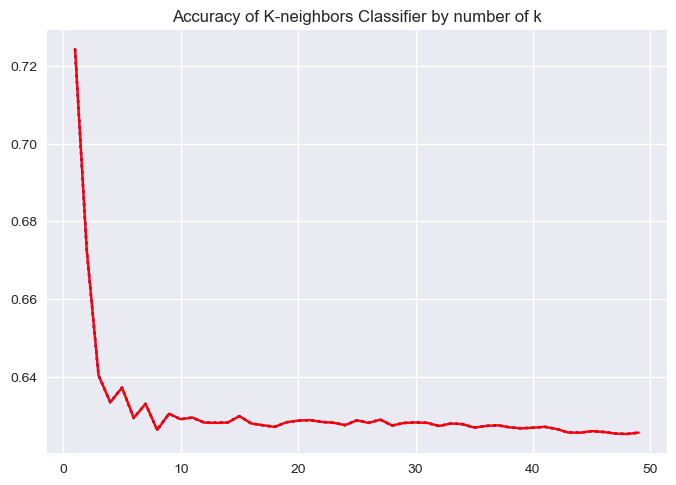

In [125]:
mu, std = sc.mean(), sc.std()
plt.style.use('seaborn')
plt.plot(mu + std, ':b')
plt.plot(mu - std, ':b')
plt.title('Accuracy of K-neighbors Classifier by number of k')
f = plt.plot(mu, 'r')

In [126]:
k = sc.mean().argmax()
print ("k =", k, "gives accuracy on optimization set of", sc.mean()[k])

k = 1 gives accuracy on optimization set of 0.724314794038


### 3.7 Gradient Boosting Classifier

In [130]:
# Gradient Boosting Classifier- After dimension deduction
model_gra = GradientBoostingClassifier(n_estimators=10)
%time cross_val_score(model_gra.fit(X_train_CV, y_train), X_test_CV,y_test).mean()

CPU times: user 6.61 s, sys: 539 ms, total: 7.15 s
Wall time: 7.17 s


0.59361619952572631

In [131]:
%time
scores = []
for n in [1, 2, 3, 5, 10, 20, 50, 100]:
    for criterion in ['gini', 'entropy']:
        start_time = time.time()  
        accuracy = cross_val_score(model_gra.fit(X_train_CV, y_train), X_test_CV,y_test).mean()  
        duration = time.time() - start_time
        scores.append(dict(n_estimators=n, criterion=criterion, accuracy=accuracy, duration=duration))
scores_gra = pd.DataFrame(scores)
scores_gra.head()

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.96 µs


,accuracy,criterion,duration,n_estimators
0,0.593616,gini,7.250359,1
1,0.593616,entropy,7.238551,1
2,0.593616,gini,7.248819,2
3,0.593616,entropy,7.119185,2
4,0.593616,gini,7.258177,3


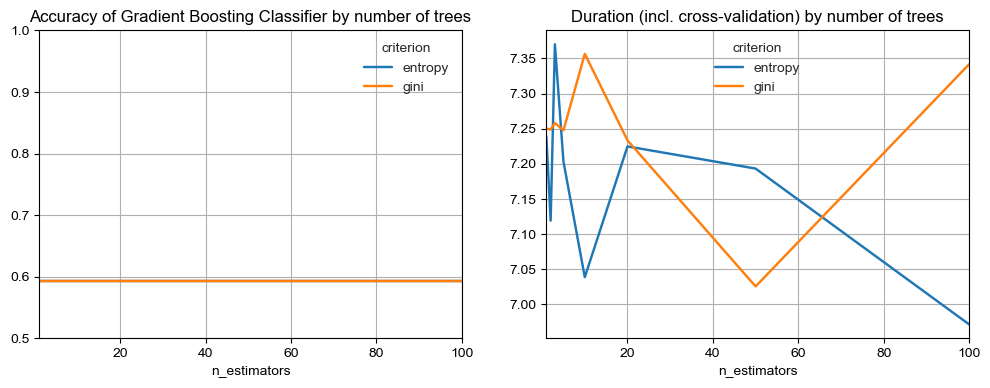

In [134]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plt.style.use('seaborn')
f = scores_gra.groupby(['n_estimators', 'criterion']).accuracy.mean().unstack() \
    .plot(ylim=(.5,1), title="Accuracy of Gradient Boosting Classifier by number of trees", ax=axes[0])
f = scores_gra.groupby(['n_estimators', 'criterion']).duration.mean().unstack() \
    .plot(title="Duration (incl. cross-validation) by number of trees", ax=axes[1])    